### Installing Requirements
```bash
pip install --user ipywidgets torchvision tqdm matplotlib
```

### Loading required packages

In [1]:
%matplotlib inline

import torch
import torch.nn.functional as F
import torchvision
import numpy
from matplotlib import pyplot as plt

try:
    from tqdm import tqdm as iter_progress
except:
    iter_progress=lambda x:x

### Have we got GPU?

In [2]:
if torch.cuda.is_available():
    print "GPU works"
    device = 'cuda'
else:
    print "CPU will have to do"
    device = 'cpu'

GPU works


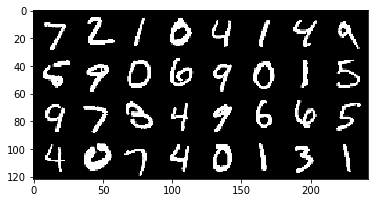

In [3]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))])

transform_test = transform_train

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2096, shuffle=True, num_workers=5)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=2096, shuffle=False, num_workers=5)

images, labels = iter(testloader).next()
img=torchvision.utils.make_grid(images[:32,:,:,:]).numpy()
plt.imshow(img.transpose(1,2,0))

### Define a simple CNN

In [4]:
class Lenet5(torch.nn.Module):
    def __init__(self):
        super(Lenet5, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, (5,5))
        self.conv2 = torch.nn.Conv2d(6, 10, (5,5))
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(160, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc_class = torch.nn.Linear(84, 10)

    def forward(self, X):
        layer1_activations=torch.tanh(self.conv1(X))
        layer2_activations=self.pool(layer1_activations)
        layer3_activations=torch.tanh(self.conv2(layer2_activations))
        layer4_activations=self.pool(layer3_activations)
        layer4_activations=layer4_activations.view([layer4_activations.size()[0],160])
        layer5_activations=torch.tanh(self.fc1(layer4_activations))
        layer6_activations=torch.tanh(self.fc2(layer5_activations))
        output_logits = self.fc_class(layer6_activations)
        return output_logits

    def save(filename):
        save.save_state_dict(filename)
        

### Define iterating over a single epoch
(For train and test)

In [5]:
def run_epoch(net,dataloader,criterion,device,optimizer=None):
    net.train()
    accumulated_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(iter_progress(dataloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        if optimizer:
            optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        if optimizer:
            loss.backward()
            optimizer.step()
        accumulated_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct,total,accumulated_loss

### Train on CPU

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 0 Train Error: 0.729683333333 Validation Error: 0.4188 Loss: 65.708479166


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 1 Train Error: 0.381683333333 Validation Error: 0.3516 Loss: 56.8300657272


100%|██████████| 5/5 [00:00<00:00,  8.89it/s]

Epoch: 2 Train Error: 0.3101 Validation Error: 0.2074 Loss: 35.3771324158


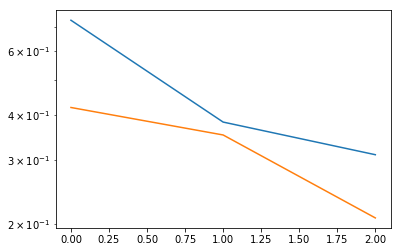

In [6]:
net=Lenet5()
net.cpu()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=.01, momentum=0.9, weight_decay=5e-4)

train_performance = []
validation_performance = []

for epoch in range(3):
    train_correct,train_total,train_loss=run_epoch(net, trainloader, criterion, 'cpu', optimizer)
    train_err=1-float(train_correct)/train_total
    test_correct,test_total,test_error=run_epoch(net, testloader, criterion, 'cpu', None)
    test_err=1-float(test_correct)/test_total
    train_performance.append(train_err)
    validation_performance.append(test_err)
    print "Epoch: {} Train Error: {} Validation Error: {} Loss: {}".format(epoch,train_err,test_err,train_loss)

plt.semilogy(train_performance)
plt.semilogy(validation_performance)

### Save the model

In [7]:
torch.save(net.state_dict(), "lenet5.pt")

### Resume the model

In [8]:
net=Lenet5()
net.cpu()
test_correct,test_total,test_error=run_epoch(net, testloader, criterion, 'cpu', None)
test_err=1-float(test_correct)/test_total
print "Initial test error {}".format(test_err)
net.load_state_dict(torch.load("lenet5.pt"))
test_correct,test_total,test_error=run_epoch(net, testloader, criterion, 'cpu', None)
test_err=1-float(test_correct)/test_total
print "Resumed test error {}".format(test_err)


  0%|          | 0/5 [00:00<?, ?it/s]

Initial test error 0.9208


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]

Resumed test error 0.2074


### Train on GPU

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 0 Train Error: 0.683833333333 Validation Error: 0.3884 Loss: 65.4000287056


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 1 Train Error: 0.354533333333 Validation Error: 0.324 Loss: 54.4367974997


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 2 Train Error: 0.277783333333 Validation Error: 0.2021 Loss: 32.2060779333


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 3 Train Error: 0.172016666667 Validation Error: 0.1328 Loss: 20.0650656223


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 4 Train Error: 0.124616666667 Validation Error: 0.1041 Loss: 14.459608525


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 5 Train Error: 0.1027 Validation Error: 0.0901 Loss: 11.5348459184


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 6 Train Error: 0.0881833333333 Validation Error: 0.0774 Loss: 9.74250626564


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 7 Train Error: 0.0785 Validation Error: 0.0689 Loss: 8.50855630636


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 8 Train Error: 0.0704166666667 Validation Error: 0.0645 Loss: 7.60724402964


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 9 Train Error: 0.0651 Validation Error: 0.0603 Loss: 6.90250752866


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 10 Train Error: 0.0605 Validation Error: 0.0558 Loss: 6.33300291002


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 11 Train Error: 0.0564 Validation Error: 0.0518 Loss: 5.87656159699


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 12 Train Error: 0.0529 Validation Error: 0.0492 Loss: 5.48494960368


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 13 Train Error: 0.0498 Validation Error: 0.0472 Loss: 5.14807800949


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 14 Train Error: 0.04715 Validation Error: 0.0449 Loss: 4.86665467918


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 15 Train Error: 0.0447666666667 Validation Error: 0.0434 Loss: 4.61011758447


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 16 Train Error: 0.0428333333333 Validation Error: 0.0418 Loss: 4.38308684528


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 17 Train Error: 0.0409166666667 Validation Error: 0.0403 Loss: 4.18304374814


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 18 Train Error: 0.0390666666667 Validation Error: 0.0391 Loss: 3.99736652523


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 19 Train Error: 0.0375833333333 Validation Error: 0.0368 Loss: 3.83869781345


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 20 Train Error: 0.0361666666667 Validation Error: 0.0349 Loss: 3.68780981004


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 21 Train Error: 0.0349166666667 Validation Error: 0.0347 Loss: 3.55101887137


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 22 Train Error: 0.0338666666667 Validation Error: 0.0332 Loss: 3.42888548225


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 23 Train Error: 0.03265 Validation Error: 0.0317 Loss: 3.30851020664


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 24 Train Error: 0.0317666666667 Validation Error: 0.0307 Loss: 3.20887996256


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 25 Train Error: 0.0307833333333 Validation Error: 0.0293 Loss: 3.10216221958


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 26 Train Error: 0.0297833333333 Validation Error: 0.0284 Loss: 3.01267367601


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 27 Train Error: 0.0288833333333 Validation Error: 0.0266 Loss: 2.93950574845


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 28 Train Error: 0.0281666666667 Validation Error: 0.0269 Loss: 2.84811482579


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 29 Train Error: 0.0275833333333 Validation Error: 0.026 Loss: 2.77550853044


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 30 Train Error: 0.0266166666667 Validation Error: 0.0261 Loss: 2.7054682374


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 31 Train Error: 0.02615 Validation Error: 0.0246 Loss: 2.64267286658


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 32 Train Error: 0.0252666666667 Validation Error: 0.0238 Loss: 2.58001883328


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 33 Train Error: 0.0245666666667 Validation Error: 0.0229 Loss: 2.53420570493


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 34 Train Error: 0.0240166666667 Validation Error: 0.0232 Loss: 2.46673739702


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 35 Train Error: 0.02345 Validation Error: 0.0222 Loss: 2.41636127979


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 36 Train Error: 0.02315 Validation Error: 0.0214 Loss: 2.37511203438


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 37 Train Error: 0.0228 Validation Error: 0.0214 Loss: 2.32442557067


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 38 Train Error: 0.0223166666667 Validation Error: 0.0208 Loss: 2.28349886835


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 39 Train Error: 0.0219333333333 Validation Error: 0.0205 Loss: 2.23419236392


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 40 Train Error: 0.0217166666667 Validation Error: 0.0205 Loss: 2.20073409006


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 41 Train Error: 0.0210666666667 Validation Error: 0.021 Loss: 2.1792405732


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 42 Train Error: 0.021 Validation Error: 0.0199 Loss: 2.12836338952


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 43 Train Error: 0.0203333333333 Validation Error: 0.0196 Loss: 2.10006128624


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 44 Train Error: 0.0202166666667 Validation Error: 0.02 Loss: 2.06169562787


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 45 Train Error: 0.0198 Validation Error: 0.0197 Loss: 2.03773223236


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 46 Train Error: 0.0193166666667 Validation Error: 0.0197 Loss: 1.99847134948


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 47 Train Error: 0.0189833333333 Validation Error: 0.0198 Loss: 1.96821414307


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 48 Train Error: 0.0187166666667 Validation Error: 0.0194 Loss: 1.94000001624


100%|██████████| 5/5 [00:00<00:00, 11.34it/s]


Epoch: 49 Train Error: 0.0185333333333 Validation Error: 0.0195 Loss: 1.92348279431


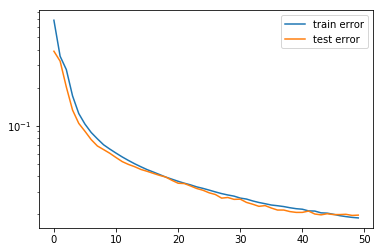

In [9]:
net=Lenet5()
if device=='cuda':
    net.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=.01, momentum=0.9, weight_decay=5e-4)

train_performance = []
validation_performance = []

for epoch in range(50):
    train_correct,train_total,train_loss=run_epoch(net, trainloader, criterion, device, optimizer)
    train_err=1-float(train_correct)/train_total
    test_correct,test_total,test_error=run_epoch(net, testloader, criterion, device, None)
    test_err=1-float(test_correct)/test_total
    train_performance.append(train_err)
    validation_performance.append(test_err)
    print "Epoch: {} Train Error: {} Validation Error: {} Loss: {}".format(epoch,train_err,test_err,train_loss)

plt.semilogy(train_performance)
plt.semilogy(validation_performance)
plt.legend(['train error','test error'])
mnist_train_performance=train_performance
mnist_validation_performance=validation_performance

### How about a more difficult dataset?

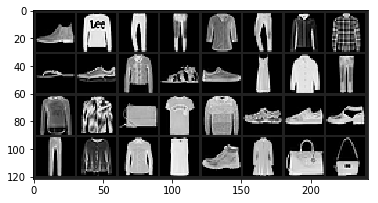

In [10]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))])

transform_test = transform_train

trainset = torchvision.datasets.FashionMNIST(root='./fashion_data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2096, shuffle=True, num_workers=5)

testset = torchvision.datasets.FashionMNIST(root='./fashion_data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=2096, shuffle=False, num_workers=5)

images, labels = iter(testloader).next()
img=torchvision.utils.make_grid(images[:32,:,:,:]).numpy()*.3+.13
plt.imshow(img.transpose(1,2,0))

### Train on the same model for a harder problem

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 0 Train Error: 0.742483333333 Validation Error: 0.564 Loss: 63.6707043648


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 1 Train Error: 0.5082 Validation Error: 0.451 Loss: 45.7477579117


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 2 Train Error: 0.419833333333 Validation Error: 0.4082 Loss: 33.7996902466


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 3 Train Error: 0.365483333333 Validation Error: 0.3407 Loss: 29.1456677914


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 4 Train Error: 0.310666666667 Validation Error: 0.2957 Loss: 25.7471805215


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 5 Train Error: 0.27875 Validation Error: 0.2761 Loss: 22.8414520621


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 6 Train Error: 0.264683333333 Validation Error: 0.267 Loss: 20.7978471518


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 7 Train Error: 0.257133333333 Validation Error: 0.2618 Loss: 19.4795618653


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 8 Train Error: 0.247266666667 Validation Error: 0.2538 Loss: 18.5497187972


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 9 Train Error: 0.239433333333 Validation Error: 0.2449 Loss: 17.7935103178


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 10 Train Error: 0.23095 Validation Error: 0.2349 Loss: 17.1572739482


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 11 Train Error: 0.22355 Validation Error: 0.2279 Loss: 16.6235550046


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 12 Train Error: 0.216183333333 Validation Error: 0.2206 Loss: 16.1738965511


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 13 Train Error: 0.2101 Validation Error: 0.2152 Loss: 15.7651387453


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 14 Train Error: 0.2061 Validation Error: 0.211 Loss: 15.418464303


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 15 Train Error: 0.200766666667 Validation Error: 0.2066 Loss: 15.094745934


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 16 Train Error: 0.197 Validation Error: 0.2024 Loss: 14.775729686


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 17 Train Error: 0.192066666667 Validation Error: 0.1976 Loss: 14.4937308431


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 18 Train Error: 0.188016666667 Validation Error: 0.1953 Loss: 14.2382565737


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 19 Train Error: 0.18365 Validation Error: 0.1897 Loss: 14.0200026631


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 20 Train Error: 0.1784 Validation Error: 0.1851 Loss: 13.7469357252


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 21 Train Error: 0.175183333333 Validation Error: 0.1809 Loss: 13.5326248109


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 22 Train Error: 0.169866666667 Validation Error: 0.1766 Loss: 13.3000222445


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 23 Train Error: 0.165266666667 Validation Error: 0.1735 Loss: 13.052290827


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 24 Train Error: 0.161916666667 Validation Error: 0.1706 Loss: 12.8631730378


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 25 Train Error: 0.157416666667 Validation Error: 0.1667 Loss: 12.6423960328


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 26 Train Error: 0.15465 Validation Error: 0.1637 Loss: 12.4790810943


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 27 Train Error: 0.1522 Validation Error: 0.1606 Loss: 12.3186948597


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 28 Train Error: 0.14925 Validation Error: 0.1595 Loss: 12.1229485571


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 29 Train Error: 0.148566666667 Validation Error: 0.1562 Loss: 12.006069988


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 30 Train Error: 0.1449 Validation Error: 0.1591 Loss: 11.7996165156


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 31 Train Error: 0.145183333333 Validation Error: 0.1525 Loss: 11.7778265476


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 32 Train Error: 0.141166666667 Validation Error: 0.151 Loss: 11.5308769941


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 33 Train Error: 0.139883333333 Validation Error: 0.1492 Loss: 11.4119955599


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 34 Train Error: 0.137966666667 Validation Error: 0.1494 Loss: 11.2521239817


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 35 Train Error: 0.1373 Validation Error: 0.1466 Loss: 11.1489563882


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 36 Train Error: 0.136633333333 Validation Error: 0.1456 Loss: 11.0411013365


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 37 Train Error: 0.13435 Validation Error: 0.1432 Loss: 10.9103147686


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 38 Train Error: 0.135183333333 Validation Error: 0.1414 Loss: 10.9537292421


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 39 Train Error: 0.132616666667 Validation Error: 0.1449 Loss: 10.7314349413


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 40 Train Error: 0.1336 Validation Error: 0.1394 Loss: 10.7331635952


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 41 Train Error: 0.1307 Validation Error: 0.1401 Loss: 10.6071522534


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 42 Train Error: 0.13065 Validation Error: 0.1397 Loss: 10.5235634446


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 43 Train Error: 0.128216666667 Validation Error: 0.1405 Loss: 10.3763130903


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 44 Train Error: 0.129466666667 Validation Error: 0.1389 Loss: 10.4259046614


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 45 Train Error: 0.12685 Validation Error: 0.1388 Loss: 10.2314409316


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 46 Train Error: 0.125383333333 Validation Error: 0.1362 Loss: 10.1427651346


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 47 Train Error: 0.1251 Validation Error: 0.1366 Loss: 10.1600523591


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 48 Train Error: 0.12535 Validation Error: 0.1358 Loss: 10.0970909894


100%|██████████| 5/5 [00:00<00:00,  9.82it/s]

Epoch: 49 Train Error: 0.123066666667 Validation Error: 0.1346 Loss: 9.98902839422


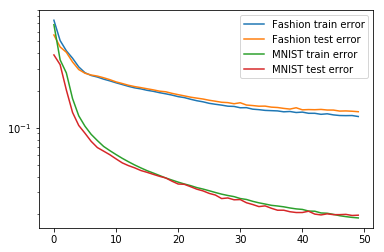

In [11]:
net=Lenet5()
if device=='cuda':
    net.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=.01, momentum=0.9, weight_decay=5e-4)

train_performance = []
validation_performance = []

for epoch in range(50):
    train_correct,train_total,train_loss=run_epoch(net, trainloader, criterion, device, optimizer)
    train_err=1-float(train_correct)/train_total
    test_correct,test_total,test_error=run_epoch(net, testloader, criterion, device, None)
    test_err=1-float(test_correct)/test_total
    train_performance.append(train_err)
    validation_performance.append(test_err)
    print "Epoch: {} Train Error: {} Validation Error: {} Loss: {}".format(epoch,train_err,test_err,train_loss)

plt.semilogy(train_performance)
plt.semilogy(validation_performance)
plt.semilogy(mnist_train_performance)
plt.semilogy(mnist_validation_performance)
plt.legend(['Fashion train error','Fashion test error','MNIST train error','MNIST test error'])

### Define a Larger Network

In [12]:
class ColorCNN(torch.nn.Module):
    def __init__(self,filename="",input_size=(32,32,3)):
        super(ColorCNN, self).__init__()
        self.input_size = input_size
        self.conv1 = torch.nn.Conv2d(3, 16, (3, 3))
        self.conv2 = torch.nn.Conv2d(16, 16, (3, 3))
        
        self.conv3 = torch.nn.Conv2d(16,32, (3, 3))
        self.conv4 = torch.nn.Conv2d(32, 32, (3, 3))
        
        activation_width = lambda x: (((x-4)/2)-4)/2
        activation_height = lambda x: (((x-4)/2)-4)/2
        
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.dropout2d = torch.nn.Dropout2d(p=0.1)
        self.dropout_fc = torch.nn.Dropout(p=0.1)
        
        self.last_conv_size=activation_width(input_size[0])*activation_height(input_size[1])*int(self.conv4.bias.shape[0])
        
        self.fc1 = torch.nn.Linear(self.last_conv_size, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc_class = torch.nn.Linear(128, 10)
        
                
    def forward(self,X):
        layer1_activations=self.dropout2d( F.relu(self.conv1(X)))
        layer2_activations=self.dropout2d( F.relu(self.conv2(layer1_activations)))
        layer3_activations=self.pool(layer2_activations)

        layer4_activations=self.dropout2d( F.relu(self.conv3(layer3_activations)))
        layer5_activations=self.dropout2d( F.relu(self.conv4(layer4_activations)))
        layer6_activations=self.pool(layer5_activations)

        layer7_activations=layer6_activations.view([layer6_activations.size()[0], self.last_conv_size])
        layer7_activations=self.dropout_fc(F.relu(self.fc1(layer7_activations)))
        layer8_activations=self.dropout_fc(F.relu(self.fc2(layer7_activations)))
        output_logits=self.fc_class(layer8_activations)
        
        return output_logits


### Load a harder dataset

Files already downloaded and verified
Files already downloaded and verified


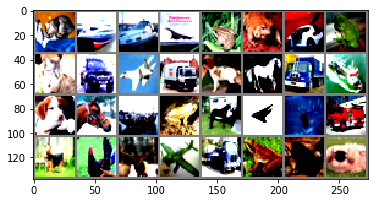

In [13]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

images, labels = iter(testloader).next()
img=torchvision.utils.make_grid(images[:32,:,:,:]).numpy() / 2 + 0.5
plt.imshow(img.transpose(1,2,0))

### Train the larger network on the hardest dataset

In [14]:
net=ColorCNN()
if device=='cuda':
    net.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=.01, momentum=0.9, weight_decay=5e-4)

train_performance = []
validation_performance = []

for epoch in range(200):
    train_correct,train_total,train_loss=run_epoch(net, trainloader, criterion, device, optimizer)
    train_err=1-float(train_correct)/train_total
    test_correct,test_total,test_error=run_epoch(net, testloader, criterion, device, None)
    test_err=1-float(test_correct)/test_total
    train_performance.append(train_acc)
    validation_performance.append(test_acc)
    print "Epoch: {} Train Error: {} Validation Error: {} Loss: {}".format(epoch,train_err,test_err,train_loss)

plt.plot(train_performance)
plt.plot(test_performance)

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 0 Train Error: 0.10038 Validation Error: 0.1004 Loss: 225.652438641


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 1 Train Error: 0.10766 Validation Error: 0.1131 Loss: 225.477940083


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 2 Train Error: 0.14778 Validation Error: 0.1993 Loss: 221.372686625


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 3 Train Error: 0.2238 Validation Error: 0.2571 Loss: 209.208384275


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 4 Train Error: 0.24816 Validation Error: 0.2814 Loss: 200.170040369


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 5 Train Error: 0.27704 Validation Error: 0.3136 Loss: 193.28186667


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 6 Train Error: 0.29782 Validation Error: 0.3339 Loss: 187.799067497


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 7 Train Error: 0.32162 Validation Error: 0.3608 Loss: 182.439646244


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 8 Train Error: 0.33912 Validation Error: 0.3818 Loss: 177.034400344


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 9 Train Error: 0.35994 Validation Error: 0.4025 Loss: 172.234669805


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 10 Train Error: 0.37586 Validation Error: 0.4179 Loss: 167.884535193


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 11 Train Error: 0.38692 Validation Error: 0.4356 Loss: 165.149345279


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 12 Train Error: 0.39744 Validation Error: 0.4446 Loss: 162.229325533


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 13 Train Error: 0.4087 Validation Error: 0.4509 Loss: 159.59139514


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 14 Train Error: 0.41742 Validation Error: 0.4572 Loss: 157.313748956


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 15 Train Error: 0.42432 Validation Error: 0.469 Loss: 155.634839296


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 16 Train Error: 0.43188 Validation Error: 0.4651 Loss: 153.315640092


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 17 Train Error: 0.4379 Validation Error: 0.4786 Loss: 151.733971953


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 18 Train Error: 0.44414 Validation Error: 0.4783 Loss: 149.966870666


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 19 Train Error: 0.45512 Validation Error: 0.4901 Loss: 148.437110901


 87%|████████▋ | 85/98 [00:04<00:00, 19.57it/s]Process Process-1134:
Process Process-1133:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
Traceback (most recent call last):
    self._target(*self._args, **self._kwargs)
  File "/home/anguelos/.local/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    samples = collate_fn([dataset[i] for i in batch_indices])
    self._target(*self._args, **self._kwargs)
  File "/home/anguelos/.local/lib/python2.7/site-packages/torchvision/datasets/cifar.py", line 121, in __getitem__
  File "/home/anguelos/.local/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop


KeyboardInterrupt: 

### Using tensofows ploting in pytorch

#### Install tensorboardX and tensorflow
```bash
pip install --user tensorboardX tensorflow
```

#### Run tensorboard 
```bash
tensorboard --logdir runs/*/
```

#### Open your browser

http://127.0.0.1:6006

In [ ]:
import tensorboardX
net=ColorCNN()
if device=='cuda':
    net.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=.01, momentum=0.9, weight_decay=5e-4)

train_performance = []
validation_performance = []

writer = tensorboardX.SummaryWriter()

for epoch in range(200):
    train_correct,train_total,train_loss=run_epoch(net, trainloader, criterion, device, optimizer)
    train_err=1-float(train_correct)/train_total
    test_correct,test_total,test_loss=run_epoch(net, testloader, criterion, device, None)
    test_err=1-float(test_correct)/test_total
    
    writer.add_scalar('error/train',train_err, epoch)
    writer.add_scalar('error/test', test_err, epoch)
    
    writer.add_scalar('loss/train', train_loss, epoch)
    writer.add_scalar('loss/test', test_loss, epoch)
    filter_image=(torchvision.utils.make_grid(net.conv1.weight).data.cpu()).numpy().transpose(1,2,0)
    writer.add_image('filters/conv1',filter_image , epoch)
    writer.add_text('text',"Epoch: {} Train Error: {} Validation Error: {} Loss: {}".format(epoch,train_err,test_err,train_loss),epoch)


 96%|█████████▌| 94/98 [00:04<00:00, 20.12it/s]